In [6]:
pip install librosa numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import librosa
import os
from itertools import combinations

def generate_spectrogram(file_path, hop_length=512, n_fft=2048):
    # Load the audio file
    signal, sr = librosa.load(file_path)
    # Generate a spectrogram
    S = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S))
    return S_db

def generate_mfcc(file_path, n_mfcc=13, n_fft=2048, hop_length=512):
    # Load the audio file
    signal, sr = librosa.load(file_path)
    # Generate MFCCs from a sound file
    mfccs = librosa.feature.mfcc(signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs

def create_pairs(audio_files_directory):
    pairs = []
    labels = []

    # List all files in the directory
    audio_files = [f for f in os.listdir(audio_files_directory) if os.path.isfile(os.path.join(audio_files_directory, f))]
    
    # Generate all possible combinations
    for pair in combinations(audio_files, 2):
        first_file_path = os.path.join(audio_files_directory, pair[0])
        second_file_path = os.path.join(audio_files_directory, pair[1])
        
        # Assume the first part of the filename is the track ID (before the first underscore)
        first_track_id = pair[0].split("_")[0]
        second_track_id = pair[1].split("_")[0]
        
        # If they have the same ID, they are from the same track
        label = int(first_track_id == second_track_id)
        
        pairs.append((first_file_path, second_file_path))
        labels.append(label)
    
    return pairs, labels

# Example usage:
audio_files_directory = '/Users/chamudi/Desktop/songs'
pairs, labels = create_pairs(audio_files_directory)

# You can then loop through these pairs to convert them into spectrograms or MFCCs
for pair, label in zip(pairs, labels):
    first_audio_features = generate_mfcc(pair[0])  # or generate_spectrogram(pair[0])
    second_audio_features = generate_mfcc(pair[1])  # or generate_spectrogram(pair[1])
    
    # Here, you would feed first_audio_features and second_audio_features into your Siamese network
    # The `label` indicates whether the pair is from the same track (1) or different tracks (0)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K

def initialize_base_network(input_shape):
    """
    Define the base network (which will be shared, acting as a feature extractor).
    """
    input_layer = Input(shape=input_shape)
    
    # Example CNN architecture
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return Model(inputs=input_layer, outputs=x)

def euclidean_distance(vectors):
    """
    Compute the Euclidean distance between two vectors.
    """
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# Define the tensors for the two input images
input_shape = (20, 257, 1)  # Example input shape (e.g., for MFCCs with 20 coefficients and 257 time steps)
left_input = Input(shape=input_shape)
right_input = Input(shape=input_shape)

# Shared CNN base
base_network = initialize_base_network(input_shape)

# Because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_left = base_network(left_input)
processed_right = base_network(right_input)

# Calculate the distance
distance = Lambda(euclidean_distance, 
                  output_shape=euclidean_distance_output_shape)([processed_left, processed_right])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1, activation='sigmoid')(distance)

# Define the model that takes as input the two images
# and outputs the prediction of whether they are from the same track
model = Model(inputs=[left_input, right_input], outputs=prediction)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to check your model
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 257,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20, 257,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │  1,542,656 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,542,658 (5.88 MB)

 Trainable params: 1,542,658 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Hypothetical example to define variables
# Let's assume your processed audio features are stored in 'features.npy' and labels in 'labels.npy'
# These files should be the result of your preprocessing steps

# For demonstration purposes, let's create some dummy data
import numpy as np

# Creating dummy data as an example
num_samples = 1000  # Number of samples in your dataset
input_shape = (20, 257, 1)  # Example shape of your preprocessed audio features

# Randomly generate data
X_dummy = np.random.rand(num_samples, *input_shape)
Y_dummy = np.random.randint(2, size=num_samples)

# Simulate splitting of data into pairs
X_train_1 = X_dummy[:num_samples//2]
X_train_2 = X_dummy[num_samples//2:]
Y_train = Y_dummy[:num_samples//2]  # Assuming the first half matches the second half in some way for training

# Import the required library for splitting the data
from sklearn.model_selection import train_test_split

# Splitting the dummy data
X_train_1, X_val_1, X_train_2, X_val_2, Y_train, Y_val = train_test_split(X_train_1, X_train_2, Y_train, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Corrected ModelCheckpoint filepath extension
checkpoint = ModelCheckpoint('siamese_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4676 - loss: 0.2529 - val_accuracy: 0.5300 - val_loss: 0.2703
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4691 - loss: 0.2123 - val_accuracy: 0.5300 - val_loss: 0.2769
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4931 - loss: 0.1884 - val_accuracy: 0.5300 - val_loss: 0.2847
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4938 - loss: 0.1680 - val_accuracy: 0.5300 - val_loss: 0.2963
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4885 - loss: 0.1636 - val_accuracy: 0.5300 - val_loss: 0.2985
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4292 - loss: 0.1485 - val_accuracy: 0.5300 - val_loss: 0.3009
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4012 - loss: 0.1400 - val_accuracy: 0.5300 - val_loss: 0.2955
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4147 - loss: 0.1481 - val_accuracy: 0.5300 - v

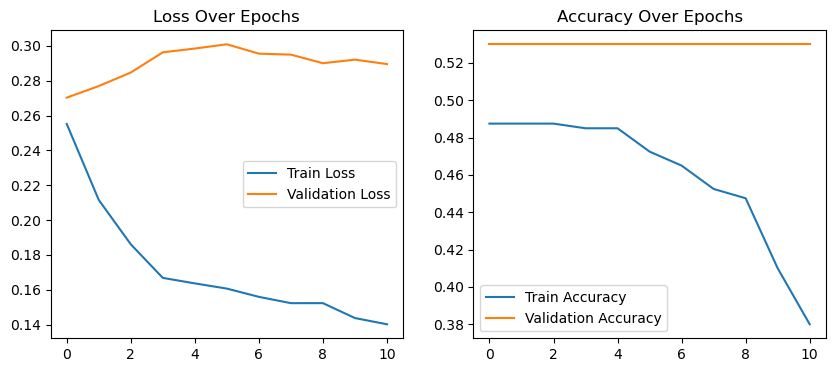

In [11]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Assuming num_samples represents the total number of samples BEFORE creating pairs
num_samples = 1000  # Total number of samples
input_shape = (20, 257, 1)  # Example shape of your preprocessed audio features

# Generate dummy feature data
X_dummy = np.random.rand(num_samples, *input_shape)

# Generate dummy labels
# Assuming half of the pairs are from the same class (1) and half are not (0)
Y_dummy = np.random.randint(2, size=(num_samples // 2, 1))

# Split the dummy feature data into two halves to simulate pairs
X_train_1 = X_dummy[:num_samples // 2]
X_train_2 = X_dummy[num_samples // 2:]

# Correctly split the dataset into training and validation sets
X_train_1, X_val_1, X_train_2, X_val_2, Y_train, Y_val = train_test_split(
    X_train_1, X_train_2, Y_dummy, test_size=0.2, random_state=42)

# Train the model
history = model.fit([X_train_1, X_train_2], Y_train,
                    validation_data=([X_val_1, X_val_2], Y_val),
                    epochs=20,  # Adjust based on your model and data
                    batch_size=32,
                    callbacks=[checkpoint, early_stopping])

# To visualize the training process, you can plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [18]:
def identify_track(unknown_feature, known_features_db):
    """
    Identify an unknown music track by comparing its feature against a database of known track features.
    
    Parameters:
    - unknown_feature: The feature vector of the unknown music snippet.
    - known_features_db: A list or array of feature vectors for known tracks.
    
    Returns:
    - identified_index: The index of the identified track in the known_features_db.
    """
    min_distance = float('inf')
    identified_index = -1

    for i, known_feature in enumerate(known_features_db):
        # Model prediction; adjust depending on whether your model returns similarity or distance
        # Here, we assume a lower score means closer match
        distance = model.predict([unknown_feature, known_feature])

        if distance < min_distance:
            min_distance = distance
            identified_index = i

    return identified_index

# Load the feature of an unknown music snippet
# unknown_feature = load_and_preprocess('path/to/unknown/snippet')

# Load your database of known track features
# known_features_db = load_your_known_features_database()

# Perform identification
# identified_index = identify_track(unknown_feature, known_features_db)
# print(f"Identified Track Index: {identified_index}")


In [30]:
import librosa
import numpy as np

def load_and_preprocess(audio_path, n_mfcc=13, n_fft=2048, hop_length=512, duration=5, sr=22050):
    """Load an audio file, extract MFCCs, and pad/truncate to a fixed size."""
    signal, _ = librosa.load(audio_path, sr=sr, duration=duration)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    
    # Padding or truncating the MFCC sequence to a fixed size
    # Assuming 'max_length' is the maximum length of sequences your model was trained on
    max_length = 216  # Example fixed length
    if mfccs.shape[1] > max_length:
        mfccs = mfccs[:, :max_length]
    else:
        padding = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, padding)), 'constant', constant_values=(0, 0))
    
    # Reshape for the model (assuming your model expects a 4D tensor)
    mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
    
    return mfccs

# Example usage
unknown_feature = load_and_preprocess('/Users/chamudi/Desktop/songs/unknown_data/11.mp3')


In [31]:
pip install --upgrade librosa

Note: you may need to restart the kernel to use updated packages.


In [32]:
# High-level pseudo-code; adjust based on your actual data and paths

# Assuming test_audio_files_directory is a directory with your test audio files organized in a way
# that you can create pairs for testing
test_audio_files_directory = '/Users/chamudi/Desktop/songs/test_data'

# Assuming a function similar to create_pairs to generate test pairs and their labels
# This function should be adjusted to work with your test data
test_pairs, test_labels = create_pairs(test_audio_files_directory)

# Now, process these pairs to generate X_test_1 and X_test_2
X_test_1 = []
X_test_2 = []

for pair in test_pairs:
    first_audio_features = generate_mfcc(pair[0])  # Or your chosen feature extraction method
    second_audio_features = generate_mfcc(pair[1])
    
    X_test_1.append(first_audio_features)
    X_test_2.append(second_audio_features)

X_test_1 = np.array(X_test_1)
X_test_2 = np.array(X_test_2)
Y_test = np.array(test_labels)

# Now, X_test_1, X_test_2, and Y_test are prepared and can be used for evaluation as shown earlier.


TypeError: mfcc() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given